
### LLC4320 : Comparison Eulerian and Lagrangian basics statistics (mean velocity fields and variance)

Notation : 

Operators:
1) $\overline{.}$ : temporal mean (Eulerian framework)
2) $<.>_b$ : binned average, space only
3) $<.>_{b,t}$ : binned average, time and space

Velocity fields : 
1) Lagrangian raw velocity : u_L
2) Eulerian raw velocity : u_E
3) Eulerian temporal mean interpolated over the drifters trajectory : $\bar u_{E,i}$



In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5483682.datarmor0/parcels-502090/libparcels_random_364fc0f4-a4d8-4ca5-ae81-50fe9bbbfe00.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=4)
#
client = Client(cluster)



In [4]:
client

<Client: 'tcp://10.148.0.139:43462' processes=28 threads=28, memory=447.16 GiB>

In [6]:
ds = ut.load_data(["SSU","SSV"])

In [7]:
sli= 10
grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid]).isel(i_g=slice(0,None,sli),
                                      j_g=slice(0,None,sli),i=slice(0,None,sli),j=slice(0,None,sli))

In [10]:
ds = ds.sel(face=1).drop(['j_g','i_g']).rename({'j_g':'j','i_g':'i'})

In [12]:
ds['zonal_velocity'] =  ds['SSU']*ds.CS - ds['SSV']*ds.SN
ds['meridional_velocity'] =  ds['SSU']*ds.SN + ds['SSV']*ds.CS

In [13]:
ds = ds.compute()

In [20]:
zonal_velocity_mean = ds.zonal_velocity.mean('time')
meridional_velocity_mean = ds.meridional_velocity.mean('time')

In [21]:
SSU_mean = ds.SSU.mean('time')
SSV_mean = ds.SSV.mean('time')

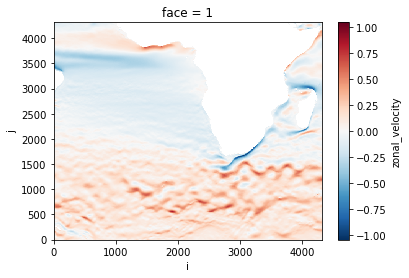

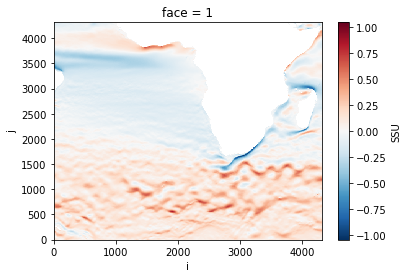

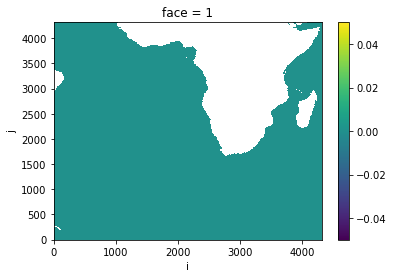

In [24]:
zonal_velocity_mean.plot()
plt.figure()
SSU_mean.plot()
plt.figure()
np.abs(zonal_velocity_mean-SSU_mean).plot()

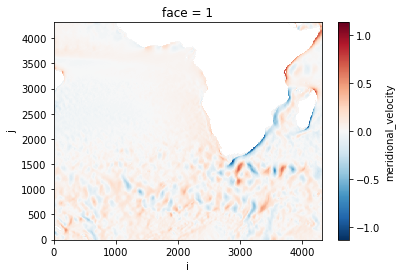

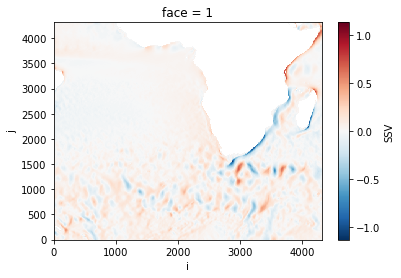

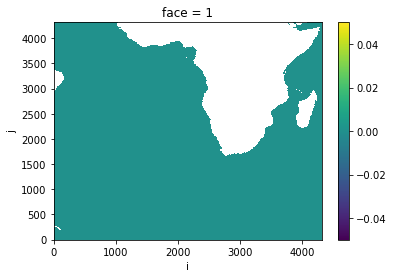

In [25]:
meridional_velocity_mean.plot()
plt.figure()
SSV_mean.plot()
plt.figure()
np.abs(meridional_velocity_mean-SSV_mean).plot()

In [26]:
ds['zonal_velocity_prime'] = ds.zonal_velocity-zonal_velocity_mean

In [28]:
ds['SSU_prime'] = ds.SSU-SSU_mean

In [61]:
zona_var = (ds.zonal_velocity_prime**2).mean('time')#.plot()
SSU_var = (ds.SSU_prime**2).mean('time')

In [96]:
SSV_mean = ds.SSV.mean('time')

In [97]:
ds['SSV_prime'] = ds.SSV-SSV_mean
SSV_var = (ds.SSV_prime**2).mean('time')

In [103]:
SSU_var_rot =  SSU_var*ds.CS - SSV_var*ds.SN
#ds['meridional_velocity'] =  ds['SSU']*ds.SN + ds['SSV']*ds.CS

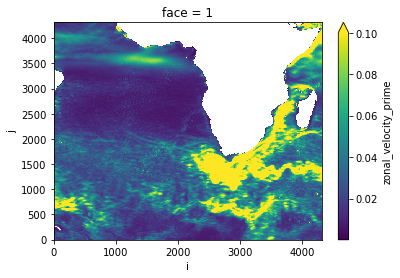

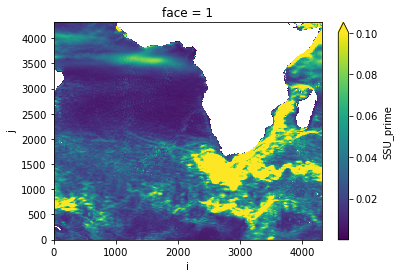

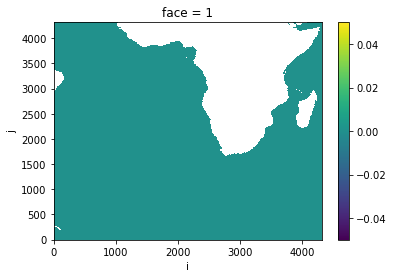

In [32]:
zona_var.plot(vmax=0.1)
plt.figure()
SSU_var.plot(vmax=0.1)
plt.figure()
np.abs(zona_var-SSU_var).plot()

In [36]:
llc_lon, llc_lat = ds.XC.compute(), ds.YC.compute()
extent = [float(llc_lon.min()), float(llc_lon.max()), 
          float(llc_lat.min()), float(llc_lat.max()),
         ]
extent

[-37.98958206176758, 51.80208206176758, -57.00102615356445, 13.560321807861328]

In [39]:
_ds_Lstats = ds_Lstats.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))

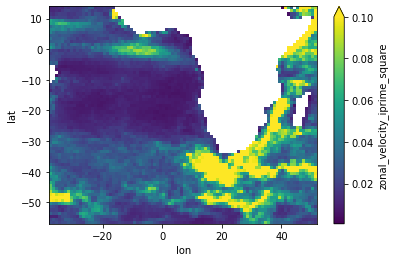

In [45]:
_ds_Lstats.zonal_velocity_iprime_square.plot(y='lat',vmax=0.1)

In [49]:
zona_var

<xarray.DataArray 'zonal_velocity_prime' (j: 432, i: 432)>
array([[0.02696807, 0.02971484, 0.02895694, ..., 0.01538342, 0.014508  ,
        0.0143037 ],
       [0.02674679, 0.02780097, 0.02641707, ..., 0.0169673 , 0.01610722,
        0.0154359 ],
       [0.02797662, 0.02787888, 0.02541868, ..., 0.01905533, 0.01681905,
        0.01549846],
       ...,
       [0.01243569, 0.01336911, 0.01265947, ..., 0.06825276, 0.08351848,
        0.10557187],
       [0.01400304, 0.01296766, 0.01330398, ..., 0.07224116, 0.08978472,
        0.12865473],
       [0.01352893, 0.01219131, 0.01264969, ..., 0.08321193, 0.10397644,
        0.14480281]], dtype=float32)
Coordinates: (12/18)
    face     int64 1
  * j        (j) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
  * i        (i) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
    CS       (j, i) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    Depth    (j, i) float32 3.047e+03 3.444e+03 ... 2.548e+03 2.002e+03
    SN       (j, i) float32 6.261e-13 -3.133e-13 ... -4.386e-14 1.754e-13
    ...       ...
    dyC      (j, i) float32 1.231e+03 1.231e+03 ... 2.074e+03 2.074e+03
    dyG      (j, i) float32 1.231e+03 1.231e+03 ... 2.074e+03 2.074e+03
    rA       (j, i) float32 1.553e+06 1.553e+06 1.553e+06 ... 4.67e+06 4.67e+06
    rAs      (j, i) float32 1.552e+06 1.552e+06 ... 4.671e+06 4.671e+06
    rAw      (j, i) float32 1.553e+06 1.553e+06 1.553e+06 ... 4.67e+06 4.67e+06
    rAz      (j, i) float32 1.552e+06 1.552e+06 ... 4.671e+06 4.671e+06

In [62]:
zona_var['lon'] = 0*zona_var.face+zona_var.XC
zona_var['lat'] = 0*zona_var.face+zona_var.YC

In [104]:
SSU_var['lon'] = 0*SSU_var.face+SSU_var.XC
SSU_var['lat'] = 0*SSU_var.face+SSU_var.YC

AttributeError: 'DataArray' object has no attribute 'face'

In [105]:
SSU_var_rot['lon'] = 0*SSU_var_rot.face+SSU_var_rot.XC
SSU_var_rot['lat'] = 0*SSU_var_rot.face+SSU_var_rot.YC

In [69]:
zona_var = zona_var.drop([C for C in zona_var.coords][3:-2])
zona_var = zona_var.drop(['face'])


df_E = zona_var.to_dataframe()    

In [84]:
SSU_var = SSU_var.drop([C for C in SSU_var.coords][3:-2])
SSU_var = SSU_var.drop(['face'])


df_EU = SSU_var.to_dataframe()    

In [106]:
SSU_var_rot

<xarray.DataArray (j: 432, i: 432)>
array([[0.02696807, 0.02971484, 0.02895694, ..., 0.01538342, 0.014508  ,
        0.0143037 ],
       [0.02674679, 0.02780097, 0.02641707, ..., 0.0169673 , 0.01610722,
        0.0154359 ],
       [0.02797662, 0.02787888, 0.02541868, ..., 0.01905533, 0.01681905,
        0.01549846],
       ...,
       [0.01243569, 0.01336911, 0.01265947, ..., 0.06825276, 0.08351848,
        0.10557187],
       [0.01400304, 0.01296766, 0.01330398, ..., 0.07224116, 0.08978472,
        0.12865473],
       [0.01352893, 0.01219131, 0.01264969, ..., 0.08321193, 0.10397644,
        0.14480281]], dtype=float32)
Coordinates: (12/20)
  * j        (j) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
  * i        (i) int64 0 10 20 30 40 50 60 ... 4260 4270 4280 4290 4300 4310
    lon      (j, i) float64 -37.99 -37.78 -37.57 -37.36 ... 51.39 51.59 51.8
    lat      (j, i) float64 -57.0 -57.0 -57.0 -57.0 ... 13.56 13.56 13.56 13.56
    face     int64 1
    CS       (j, i) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    ...       ...
    dyC      (j, i) float32 1.231e+03 1.231e+03 ... 2.074e+03 2.074e+03
    dyG      (j, i) float32 1.231e+03 1.231e+03 ... 2.074e+03 2.074e+03
    rA       (j, i) float32 1.553e+06 1.553e+06 1.553e+06 ... 4.67e+06 4.67e+06
    rAs      (j, i) float32 1.552e+06 1.552e+06 ... 4.671e+06 4.671e+06
    rAw      (j, i) float32 1.553e+06 1.553e+06 1.553e+06 ... 4.67e+06 4.67e+06
    rAz      (j, i) float32 1.552e+06 1.552e+06 ... 4.671e+06 4.671e+06

In [108]:
#SSU_var_rot = SSU_var_rot.drop([C for C in SSU_var_rot.coords][4:])
#SSU_var_rot = SSU_var_rot.drop(['face'])

SSU_var_rot.name = 'SSU_prime_rot'
df_EU_rot = SSU_var_rot.to_dataframe()    

In [71]:
dl = 1.
ds_Estats = binned_mean(df_E,dl)

ds_Estats

<xarray.Dataset>
Dimensions:               (lat: 139, lon: 359)
Coordinates:
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
  * lat                   (lat) float64 -69.5 -68.5 -67.5 ... 66.5 67.5 68.5
Data variables:
    zonal_velocity_prime  (lon, lat) float32 nan nan nan nan ... nan nan nan nan

In [85]:
dl = 1.
ds_EstatsU = binned_mean(df_EU,dl)

ds_EstatsU

<xarray.Dataset>
Dimensions:    (lat: 139, lon: 359)
Coordinates:
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5
  * lat        (lat) float64 -69.5 -68.5 -67.5 -66.5 ... 65.5 66.5 67.5 68.5
Data variables:
    SSU_prime  (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan nan

In [109]:
dl = 1.
ds_EstatsU_rot = binned_mean(df_EU_rot,dl)

ds_EstatsU_rot

<xarray.Dataset>
Dimensions:        (lat: 139, lon: 359)
Coordinates:
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat            (lat) float64 -69.5 -68.5 -67.5 -66.5 ... 65.5 66.5 67.5 68.5
Data variables:
    SSU_prime_rot  (lon, lat) float32 nan nan nan nan nan ... nan nan nan nan

In [90]:
ds_Estats["SSU_prime"]=ds_EstatsU.SSU_prime

In [110]:
ds_Estats["SSU_prime_rot"]=ds_EstatsU_rot.SSU_prime_rot

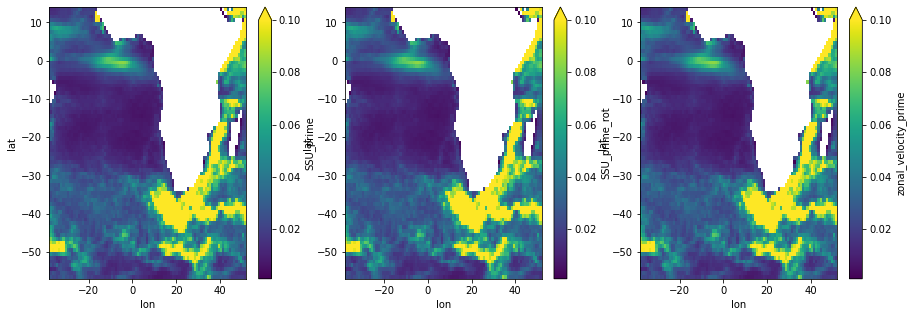

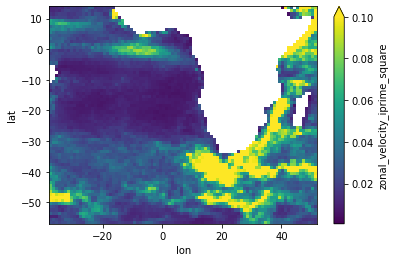

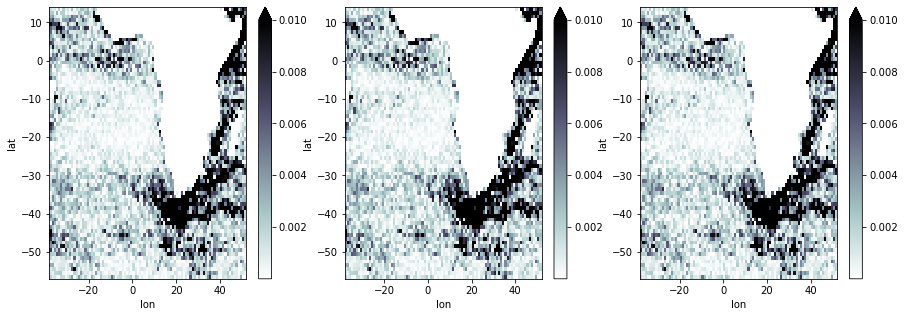

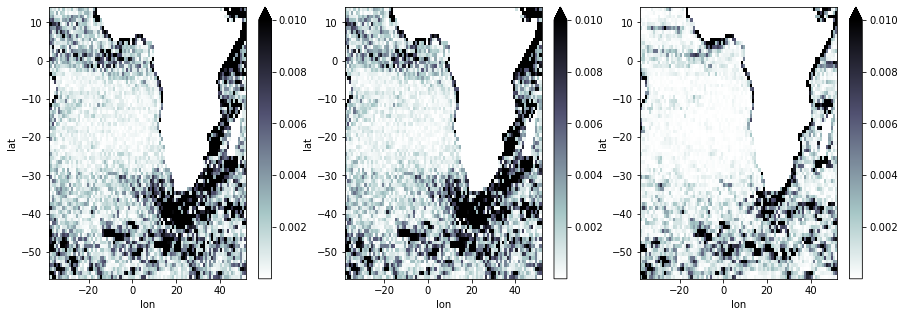

In [112]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ds_Estats.SSU_prime.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3])).plot(y='lat',vmax=0.1,ax=ax[0])
ds_Estats.SSU_prime_rot.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3])).plot(y='lat',vmax=0.1,ax=ax[1])
ds_Estats.zonal_velocity_prime.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3])).plot(y='lat',vmax=0.1,ax=ax[2])

plt.figure()
_ds_Lstats.zonal_velocity_iprime_square.plot(y='lat',vmax=0.1)
fig,ax = plt.subplots(1,3,figsize=(15,5))
np.abs(ds_Estats.SSU_prime.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))-_ds_Lstats.zonal_velocity_iprime_square).plot(y='lat',vmax=0.01,cmap='bone_r',ax=ax[0])
np.abs(ds_Estats.zonal_velocity_prime.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))-_ds_Lstats.zonal_velocity_iprime_square).plot(y='lat',vmax=0.01,cmap='bone_r',ax=ax[1])
np.abs(ds_Estats.SSU_prime_rot.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))-_ds_Lstats.zonal_velocity_iprime_square).plot(y='lat',vmax=0.01,cmap='bone_r',ax=ax[2])
fig,ax = plt.subplots(1,3,figsize=(15,5))
np.abs(ds_Estats.SSU_prime.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))-_ds_Lstats.zonal_velocity_bprime_square).plot(y='lat',vmax=0.01,cmap='bone_r',ax=ax[0])
np.abs(ds_Estats.zonal_velocity_prime.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))-_ds_Lstats.zonal_velocity_bprime_square).plot(y='lat',vmax=0.01,cmap='bone_r',ax=ax[1])
np.abs(_ds_Lstats.zonal_velocity_iprime_square-_ds_Lstats.zonal_velocity_bprime_square).plot(y='lat',vmax=0.01,cmap='bone_r',ax=ax[2])

In [ ]:
ds_EstatsU.SSU_prime.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3])).plot(y='lat',vmax=0.1)
#plt.xlim(extent[0],extent[1])
#plt.ylim(extent[2],extent[3])
plt.figure()
_ds_Lstats.zonal_velocity_iprime_square.plot(y='lat',vmax=0.1)
plt.figure()
np.abs(ds_Estats.zonal_velocity_prime.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))-_ds_Lstats.zonal_velocity_iprime_square).plot(y='lat',vmax=0.01,cmap='bone_r')

### Load data

In [33]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [34]:
#ds_Lstats = p.load_diagnostic('L_dl1.0_stats.zarr')
ds_Lstats = p.load_diagnostic('L_dl1.0_stats.zarr')
ds_Lstats = ds_Lstats.compute()

In [7]:
ds_Lstats

<xarray.Dataset>
Dimensions:                            (lat: 179, lon: 359)
Coordinates:
  * lat                                (lat) float64 -89.5 -88.5 ... 87.5 88.5
  * lon                                (lon) float64 -179.5 -178.5 ... 178.5
Data variables: (12/30)
    EKE                                (lon, lat) float64 nan nan ... nan nan
    EKE_binned                         (lon, lat) float64 nan nan ... nan nan
    EKE_ibinned                        (lon, lat) float64 nan nan ... nan nan
    KE                                 (lon, lat) float64 nan nan ... nan nan
    mean_KE                            (lon, lat) float64 nan nan ... nan nan
    mean_KE_binned                     (lon, lat) float64 nan nan ... nan nan
    ...                                 ...
    zonal_velocity_binned_iprime       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_square              (lon, lat) float64 nan nan ... nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

### Eulerian diagnostics

In [8]:
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean","variance","mean_square"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])
grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid])
sub = 2
ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub),i_g=slice(0,None,sub),j_g=slice(0,None,sub))
#ds = ds.where(ds.Depth>500, drop=False)
ds = ds.persist()
print(ds)

<xarray.Dataset>
Dimensions:          (face: 13, i: 2160, i_g: 2160, j: 2160, j_g: 2160)
Coordinates: (12/20)
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g              (i_g) int64 0 2 4 6 8 10 ... 4308 4310 4312 4314 4316 4318
  * j                (j) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * i                (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j_g              (j_g) int64 0 2 4 6 8 10 ... 4308 4310 4312 4314 4316 4318
    CS               (face, j, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    ...               ...
    dyC              (face, j_g, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    dyG              (face, j, i_g) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    rA               (face, j, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    rAs              (face, j_g, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=

In [9]:
ds = ds.drop(['i_g','j_g'])

ds = ds.rename({'i_g':'i','j_g':'j'})

ds = ds.compute()

In [46]:
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC

In [22]:
ds.CS

<xarray.DataArray 'CS' (face: 13, j: 2160, i: 2160)>
array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
        [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
        [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00]],

       [[ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
        [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
        [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
...
        [-8.7776052e-14,  8.7762114e-14, -1.3161537e-13, ...,
          3.1269681e-13, -0.0000000e+00,  3.1306896e-13],
        [-4.3888026e-14,  1.3163968e-13,  8.7741270e-14, ...,
          3.1260389e-13,  6.2576555e-13, -9.3123451e-17],
        [ 4.3888026e-14, -8.7755154e-14, -0.0000000e+00, ...,
         -6.2520778e-13, -3.1278975e-13,  6.2613792e-13]],

       [[ 9.3976617e-13, -0.0000000e+00, -0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 3.1325539e-13, -6.2688402e-13,  3.1362884e-13, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-0.0000000e+00,  3.1334866e-13, -3.1353538e-13, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [-3.1316215e-13, -0.0000000e+00, -0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 3.1325539e-13, -6.2688402e-13,  9.3447500e-17, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 3.1325539e-13, -0.0000000e+00, -0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)
Coordinates: (12/18)
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
  * i        (i) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
    CS       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Depth    (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SN       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...       ...
    dyC      (face, j, i) float32 239.5 239.5 239.5 239.6 ... 324.6 324.6 324.6
    dyG      (face, j, i) float32 479.0 479.0 479.1 479.1 ... 324.6 324.6 324.6
    rA       (face, j, i) float32 1.555e+05 1.555e+05 ... 1.556e+05 1.555e+05
    rAs      (face, j, i) float32 7.774e+04 7.775e+04 ... 1.557e+05 1.555e+05
    rAw      (face, j, i) float32 1.555e+05 1.555e+05 ... 1.557e+05 1.555e+05
    rAz      (face, j, i) float32 7.774e+04 7.775e+04 ... 1.557e+05 1.555e+05
Attributes:
    coordinate:     YC XC
    long_name:      AngleCS
    standard_name:  Cos of grid orientation angle
    units:

In [11]:
ds['zonal_velocity_mean'] =  ds['mean'+'_SSU']*ds.CS - ds["mean"+'_SSV']*ds.SN
ds['meridional_velocity_mean'] =  ds['mean'+'_SSU']*ds.SN + ds["mean"+'_SSV']*ds.CS

In [12]:
ds['zonal_velocity_var'] =  np.abs(ds['variance'+'_SSU']*ds.CS - ds["variance"+'_SSV']*ds.SN)
ds['meridional_velocity_var'] =  np.abs(ds['variance'+'_SSU']*ds.SN + ds["variance"+'_SSV']*ds.CS)

In [13]:
ds['zonal_velocity_mean_sq'] =  np.abs(ds['mean_square'+'_SSU']*ds.CS - ds["mean_square"+'_SSV']*ds.SN)
ds['meridional_velocity_mean_sq'] =  np.abs(ds['mean_square'+'_SSU']*ds.SN + ds["mean_square"+'_SSV']*ds.CS)

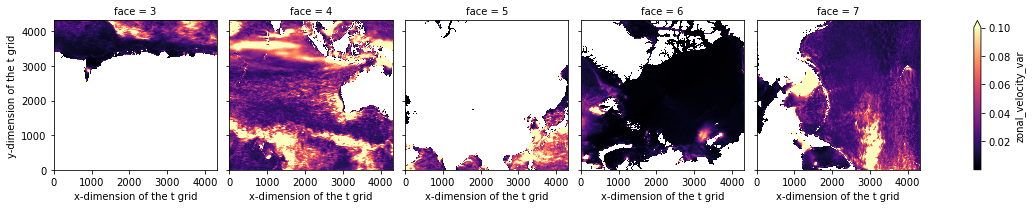

In [14]:
ds.zonal_velocity_var.isel(face=slice(3,8
                                          )).plot(col='face',vmax=0.1,cmap='magma')

#### Create xarray dataset with all faces assembled

In [16]:
ds_rot = llcreader.faces_dataset_to_latlon(ds.drop(['mean_SSU','mean_SSV','variance_SSU','variance_SSV','mean_square_SSU','mean_square_SSV']))

In [17]:
ds_rot = ds_rot.compute()
print(ds_rot)

<xarray.Dataset>
Dimensions:                      (face: 13, i: 8640, j: 6480)
Coordinates: (12/18)
  * face                         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                            (j) int64 0 1 2 3 4 ... 6476 6477 6478 6479
  * i                            (i) int64 0 1 2 3 4 ... 8636 8637 8638 8639
    CS                           (j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Depth                        (j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SN                           (j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                           ...
    rAw                          (j, i) float32 1.555e+05 ... 1.141e+04
    rAz                          (j, i) float32 7.774e+04 ... 1.384e+04
    dxC                          (j, i) float32 324.6 324.6 ... 156.9 124.2
    dyC                          (j, i) float32 239.5 239.5 ... 134.9 112.4
    dyG                          (j, i) float32 479.0 479.0 ... 136.3 108.2
    dxG              

In [18]:
ds_rot = ds_rot.drop([C for C in ds_rot.zonal_velocity_mean.coords][2:])
ds_rot = ds_rot.drop(['face'])


df_rot = ds_rot.to_dataframe()    

In [52]:
def binned_mean(df,dl):
    """Average dataframe over bins width dl
    
    Parameters 
    df : dataframe with at least longitude, latitude and field to bin in columns
    dl : bin width
    
    Returns
    df_mean : dataset with averaged fields
    """
    lon = np.arange(-180.,180., dl)
    lat = np.arange(-70., 70., dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_mean = df.groupby(['lon_cut','lat_cut']).mean()
    df_mean = pa.add_geodata(df_mean)
    df_mean = (df_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    return df_mean

In [20]:
dl = 1.
ds_Estats = binned_mean(df_rot,dl)

ds_Estats

<xarray.Dataset>
Dimensions:                      (lat: 139, lon: 359)
Coordinates:
  * lon                          (lon) float64 -179.5 -178.5 ... 177.5 178.5
  * lat                          (lat) float64 -69.5 -68.5 -67.5 ... 67.5 68.5
Data variables:
    zonal_velocity_mean          (lon, lat) float32 -0.02983 0.01438 ... nan nan
    meridional_velocity_mean     (lon, lat) float32 0.02891 0.04721 ... nan nan
    zonal_velocity_var           (lon, lat) float32 0.005069 0.00766 ... nan nan
    meridional_velocity_var      (lon, lat) float32 0.004426 0.00674 ... nan nan
    zonal_velocity_mean_sq       (lon, lat) float32 0.006876 0.00827 ... nan nan
    meridional_velocity_mean_sq  (lon, lat) float32 0.005345 0.0092 ... nan nan

### Plot comparison Eulerian and Lagrangian global statistics

#### Mean flow : 
$<u_L>_{b,t}$ : binned Lagrangian raw velocity

$<\bar u_{E,i}>_{b,t}$ : binned Eulerian (temporal) mean field interpolaed over drifters trajectories

$<\bar u_E>_b$ : binned Eulerian (temporal) mean field

In [18]:
ds_Lstats = ds_Lstats.drop([k for k in ds_Lstats.keys() if k.startswith('E') or k.startswith('mean_KE') or k.startswith('velocity')])

In [24]:
def plot_maps(ds,vmax,colmap='RdBu_r',figsize = (10,5)):
    crs = ccrs.Robinson()
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=crs)
    ds.plot(vmax=vmax,y='lat',ax=ax,transform=ccrs.PlateCarree(),cmap=colmap,label=False)
    ax.gridlines(draw_labels=True)
    return fig,ax

Text(0.5, 1.0, 'Lagrangian mean zonal velocity : $<u_{L}>_{b,t}$')

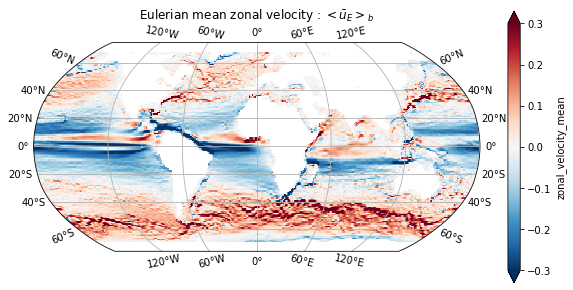

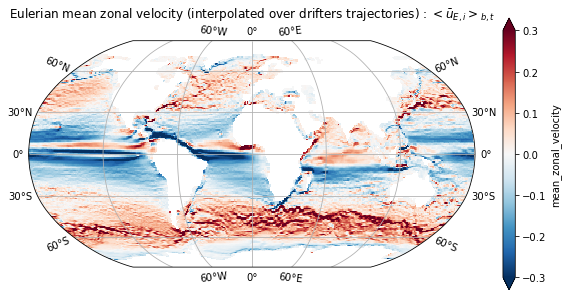

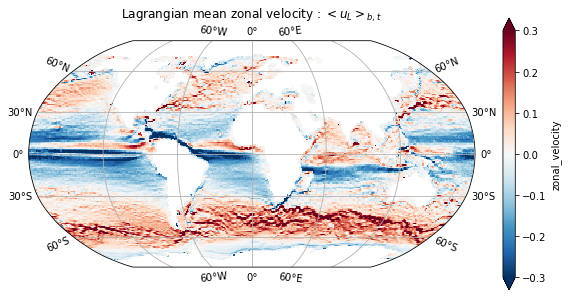

In [41]:
fig,ax = plot_maps(ds_Estats['zonal_velocity_mean'],0.3)
ax.set_title(r'Eulerian mean zonal velocity : $<\bar u_{E}>_{b}$')
fig,ax = plot_maps(ds_Lstats['mean_zonal_velocity'],0.3)
ax.set_title(r'Eulerian mean zonal velocity (interpolated over drifters trajectories) : $<\bar u_{E,i}>_{b,t}$')
fig,ax = plot_maps(ds_Lstats['zonal_velocity'],0.3)
ax.set_title(r'Lagrangian mean zonal velocity : $<u_{L}>_{b,t}$')


Text(0.5, 1.0, '$1-\\vert \\frac{<v_{L}>_{b,t}}{<\\bar v_{E}>_{b}}\\vert$')

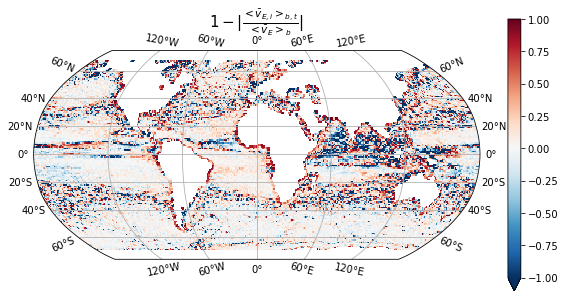

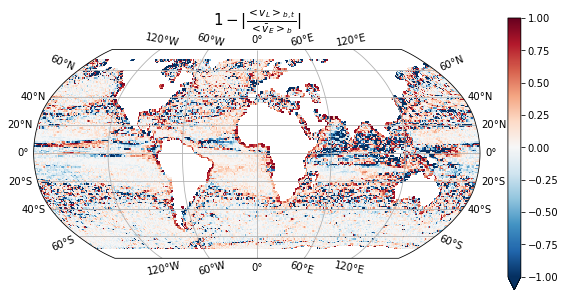

In [55]:
fig,ax = plot_maps((1-np.abs(ds_Lstats['zonal_velocity']/ds_Estats['zonal_velocity_mean'])),1)
ax.set_title(r'$1-\vert \frac{<\bar v_{E,i}>_{b,t}}{<\bar v_{E}>_{b}}\vert$',fontsize=15)
fig,ax = plot_maps((1-np.abs(ds_Lstats['zonal_velocity']/ds_Estats['zonal_velocity_mean'])),1)
ax.set_title(r'$1-\vert \frac{<v_{L}>_{b,t}}{<\bar v_{E}>_{b}}\vert$',fontsize=15)

Text(0.5, 1.0, '$\\vert <\\bar u_{E}>_{b}- <u_{L}>_{b,t}\\vert$')

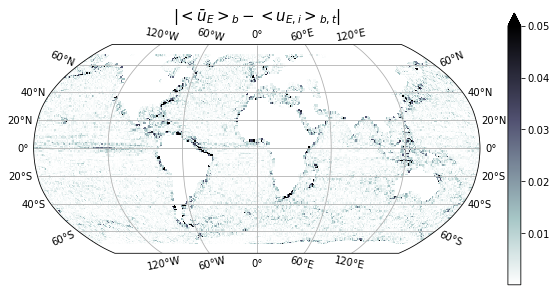

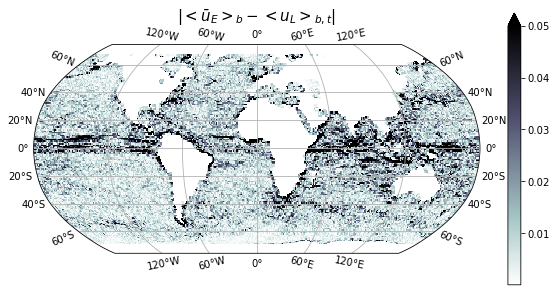

In [60]:
fig,ax = plot_maps(np.abs(ds_Estats['zonal_velocity_mean']-ds_Lstats['mean_zonal_velocity']),0.05,colmap='bone_r')
ax.set_title(r'$\vert <\bar u_{E}>_{b}- <u_{E,i}>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['zonal_velocity_mean']-ds_Lstats['zonal_velocity']),0.05,colmap='bone_r')
ax.set_title(r'$\vert <\bar u_{E}>_{b}- <u_{L}>_{b,t}\vert$',fontsize=15)

Text(0.5, 1.0, 'Lagrangian mean meridional velocity : $<v_{L}>_{b,t}$')

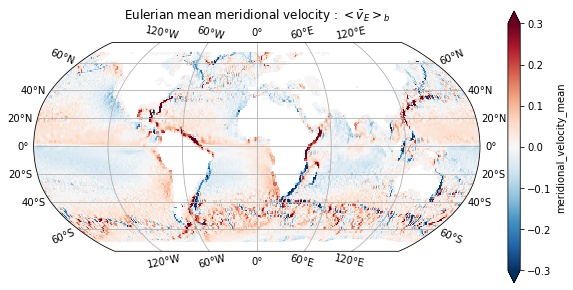

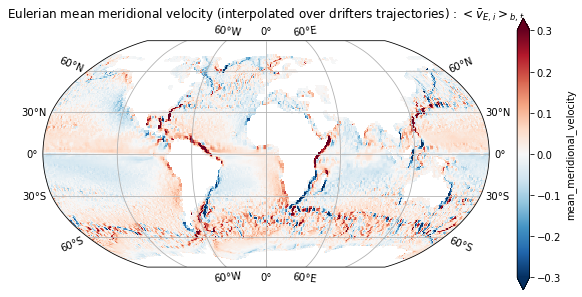

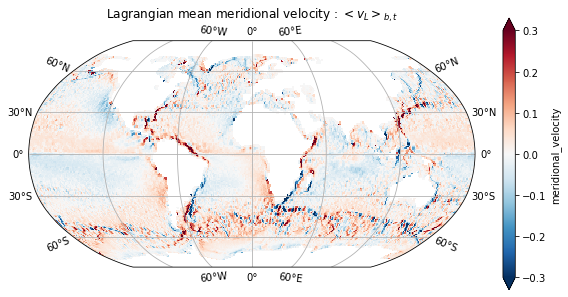

In [42]:
fig,ax = plot_maps(ds_Estats['meridional_velocity_mean'],0.3)
ax.set_title(r'Eulerian mean meridional velocity : $<\bar v_{E}>_{b}$')
fig,ax = plot_maps(ds_Lstats['mean_meridional_velocity'],0.3)
ax.set_title(r'Eulerian mean meridional velocity (interpolated over drifters trajectories) : $<\bar v_{E,i}>_{b,t}$')
fig,ax = plot_maps(ds_Lstats['meridional_velocity'],0.3)
ax.set_title(r'Lagrangian mean meridional velocity : $<v_{L}>_{b,t}$')


Text(0.5, 1.0, '$1-\\vert \\frac{<v_{L}>_{b,t}}{<\\bar v_{E}>_{b}}\\vert$')

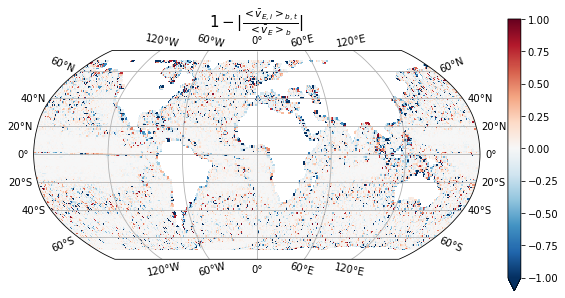

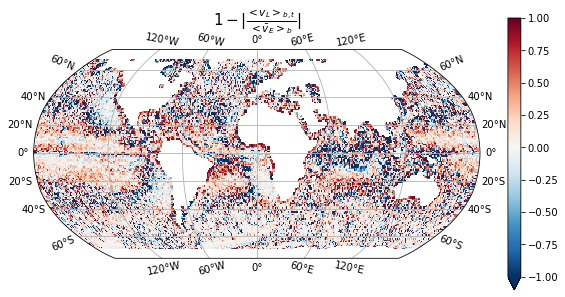

In [48]:
fig,ax = plot_maps((1-np.abs(ds_Lstats['mean_meridional_velocity']/ds_Estats['meridional_velocity_mean'])),1)
ax.set_title(r'$1-\vert \frac{<\bar v_{E,i}>_{b,t}}{<\bar v_{E}>_{b}}\vert$',fontsize=15)
fig,ax = plot_maps((1-np.abs(ds_Lstats['meridional_velocity']/ds_Estats['meridional_velocity_mean'])),1)
ax.set_title(r'$1-\vert \frac{<v_{L}>_{b,t}}{<\bar v_{E}>_{b}}\vert$',fontsize=15)

Text(0.5, 1.0, '$\\vert <\\bar v_{E}>_{b}- <v_{L}>_{b,t}\\vert$')

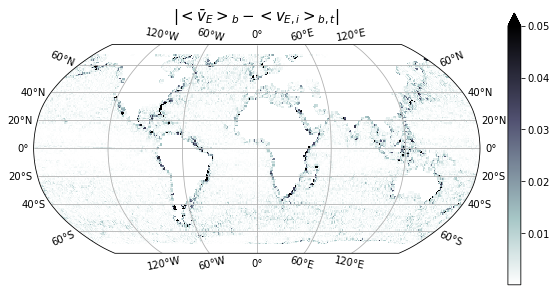

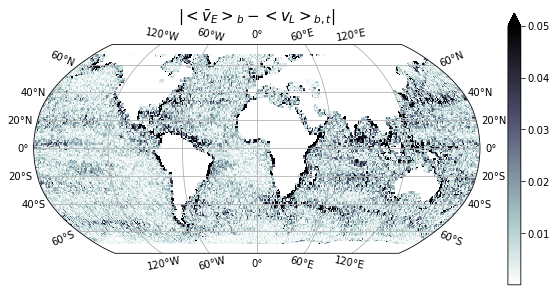

In [59]:
fig,ax = plot_maps(np.abs(ds_Estats['meridional_velocity_mean']-ds_Lstats['mean_meridional_velocity']),0.05,colmap='bone_r')
ax.set_title(r'$\vert <\bar v_{E}>_{b}- <v_{E,i}>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['meridional_velocity_mean']-ds_Lstats['meridional_velocity']),0.05,colmap='bone_r')
ax.set_title(r'$\vert <\bar v_{E}>_{b}- <v_{L}>_{b,t}\vert$',fontsize=15)

In [61]:
ds_Estats['MKE'] = ds_Estats['zonal_velocity_mean']**2+ds_Estats['meridional_velocity_mean']**2
ds_Lstats['MKE_i'] = ds_Lstats['mean_zonal_velocity']**2+ds_Lstats['mean_meridional_velocity']**2
ds_Lstats['MKE_b'] = ds_Lstats['zonal_velocity']**2+ds_Lstats['meridional_velocity']**2

Text(0.5, 1.0, 'Lagrangian mean kinetic energy : $<u_{L}>_{b,t}^2+<v_{L}>_{b,t}^2$')

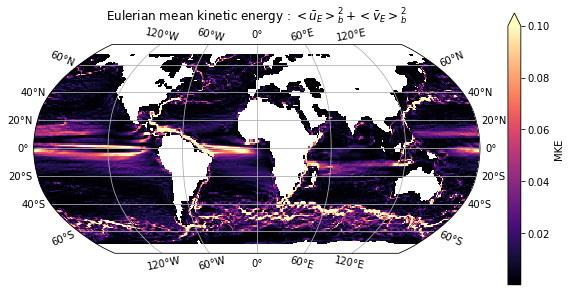

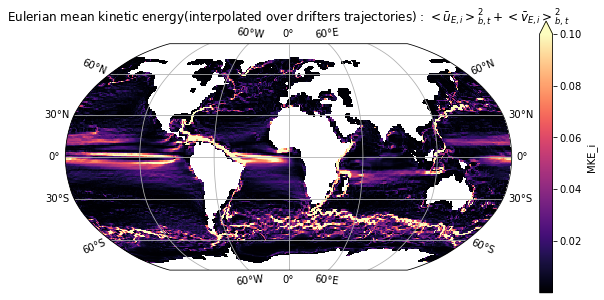

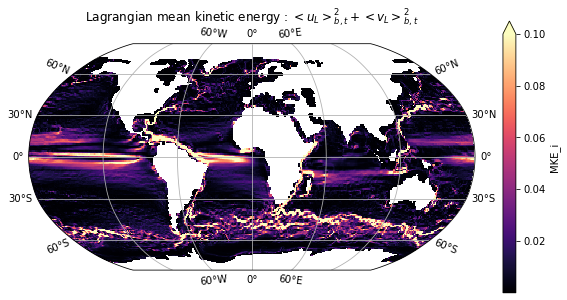

In [64]:
fig,ax = plot_maps(ds_Estats['MKE'],0.1,colmap='magma')
ax.set_title(r'Eulerian mean kinetic energy : $<\bar u_{E}>_{b}^2+<\bar v_{E}>_{b}^2$')
fig,ax = plot_maps(ds_Lstats['MKE_i'],0.1,colmap='magma')
ax.set_title(r'Eulerian mean kinetic energy(interpolated over drifters trajectories) : $<\bar u_{E,i}>_{b,t}^2+<\bar v_{E,i}>_{b,t}^2$')
fig,ax = plot_maps(ds_Lstats['MKE_i'],0.1,colmap='magma')
ax.set_title(r'Lagrangian mean kinetic energy : $<u_{L}>_{b,t}^2+<v_{L}>_{b,t}^2$')

Text(0.5, 1.0, '$\\vert <\\bar v_{E}>_{b}- <v_{L}>_{b,t}\\vert$')

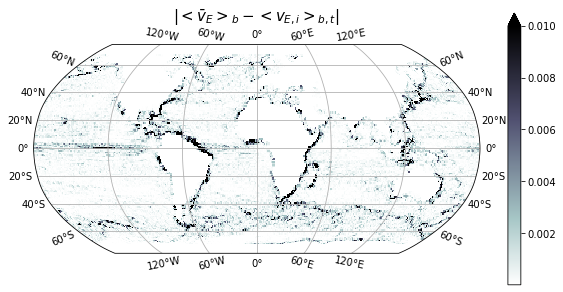

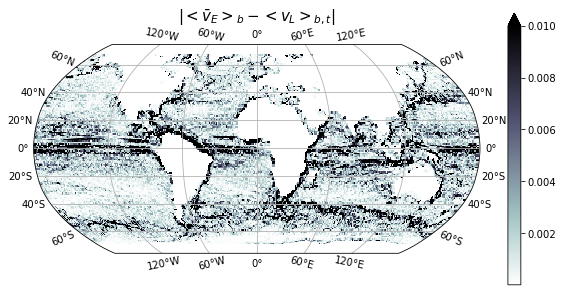

In [71]:
fig,ax = plot_maps(np.abs(ds_Estats['MKE']-ds_Lstats['MKE_i']),0.01,colmap='bone_r')
ax.set_title(r'$\vert <\bar v_{E}>_{b}- <v_{E,i}>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['MKE']-ds_Lstats['MKE_b']),0.01,colmap='bone_r')
ax.set_title(r'$\vert <\bar v_{E}>_{b}- <v_{L}>_{b,t}\vert$',fontsize=15)
#ax.coastlines()

#### Variance : 
1) $<\overline{(u_E-\bar u_E)^2}>_b$
2) $<(u_L-\bar u_{E,i})^2>_{b,t}$
3) $<(u_L-<u_L>_{b,t})^2>_{b,t}$

Text(0.5, 1.0, 'Variance of Lagrangian zonal velocity : $<(u_L-<u_L>_{b,t})^2>_{b,t}$')

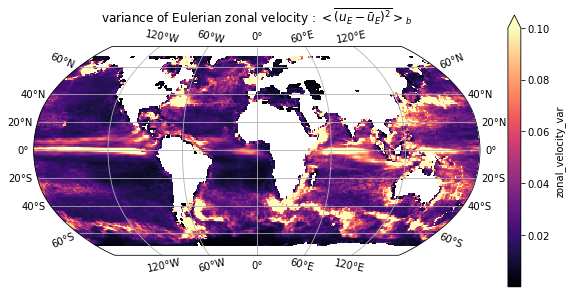

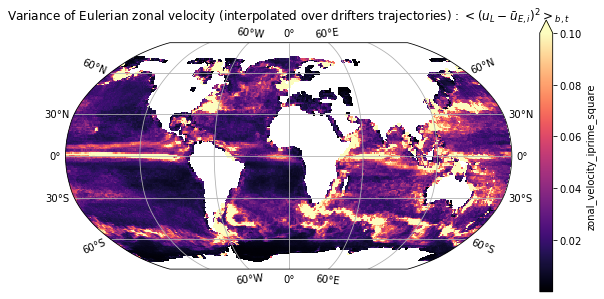

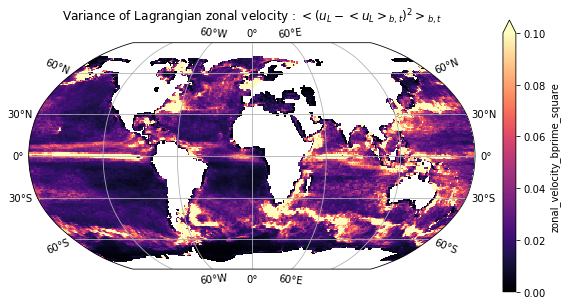

In [48]:
fig,ax = plot_maps(ds_Estats['zonal_velocity_var'],0.1,colmap='magma')
ax.set_title(r'variance of Eulerian zonal velocity : $<\overline{(u_E-\bar u_E)^2}>_b$')
fig,ax = plot_maps(ds_Lstats['zonal_velocity_iprime_square'],0.1,colmap='magma')
ax.set_title(r'Variance of Eulerian zonal velocity (interpolated over drifters trajectories) : $<(u_L-\bar u_{E,i})^2>_{b,t}$')
fig,ax = plot_maps(ds_Lstats['zonal_velocity_bprime_square'],0.1,colmap='magma')
ax.set_title(r'Variance of Lagrangian zonal velocity : $<(u_L-<u_L>_{b,t})^2>_{b,t}$')



Text(0.5, 1.0, '$\\vert <\\overline{(u_L-\\bar u_{E,i})^2}>_{b}- <(u_L-u_{L})^2>_{b,t}\\vert$')

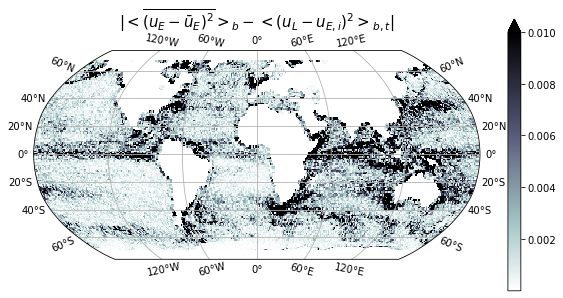

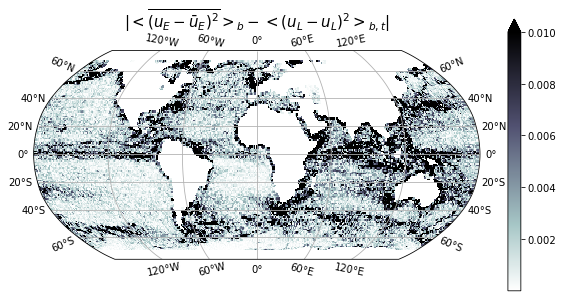

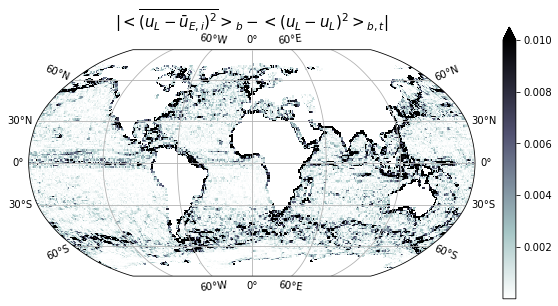

In [42]:
fig,ax = plot_maps(np.abs(ds_Estats['zonal_velocity_var']-ds_Lstats['zonal_velocity_iprime_square']),0.01,colmap='bone_r')
ax.set_title(r'$\vert <\overline{(u_E-\bar u_{E})^2}>_{b}- <(u_L-u_{E,i})^2>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['zonal_velocity_var']-ds_Lstats['zonal_velocity_bprime_square']),0.01,colmap='bone_r')
ax.set_title(r'$\vert <\overline{(u_E-\bar u_{E})^2}>_{b}- <(u_L-u_{L})^2>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Lstats['zonal_velocity_iprime_square']-ds_Lstats['zonal_velocity_bprime_square']),0.01,colmap='bone_r')
ax.set_title(r'$\vert <\overline{(u_L-\bar u_{E,i})^2}>_{b}- <(u_L-u_{L})^2>_{b,t}\vert$',fontsize=15)

Text(0.5, 1.0, 'Variance of Lagrangian meridional velocity : $<(v_L-<v_L>_{b,t})^2>_{b,t}$')

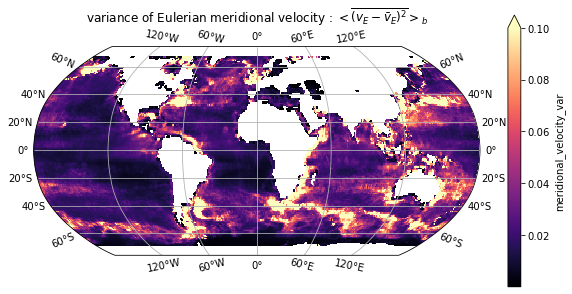

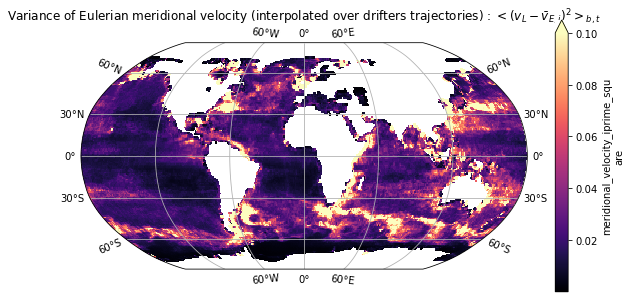

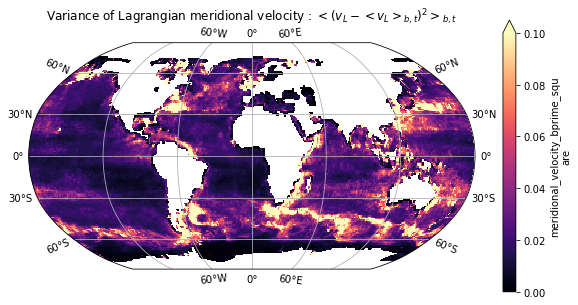

In [50]:
fig,ax = plot_maps(ds_Estats['meridional_velocity_var'],0.1,colmap='magma')
ax.set_title(r'variance of Eulerian meridional velocity : $<\overline{(v_E-\bar v_E)^2}>_b$')
fig,ax = plot_maps(ds_Lstats['meridional_velocity_iprime_square'],0.1,colmap='magma')
ax.set_title(r'Variance of Eulerian meridional velocity (interpolated over drifters trajectories) : $<(v_L-\bar v_{E,i})^2>_{b,t}$')
fig,ax = plot_maps(ds_Lstats['meridional_velocity_bprime_square'],0.1,colmap='magma')
ax.set_title(r'Variance of Lagrangian meridional velocity : $<(v_L-<v_L>_{b,t})^2>_{b,t}$')




Text(0.5, 1.0, '$\\vert <\\overline{(v_L-\\bar v_{E,i})^2}>_{b}- <(v_L-v_{L})^2>_{b,t}\\vert$')

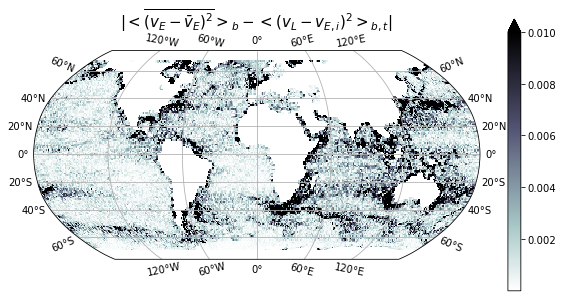

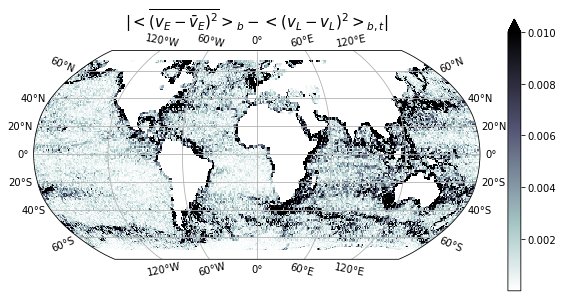

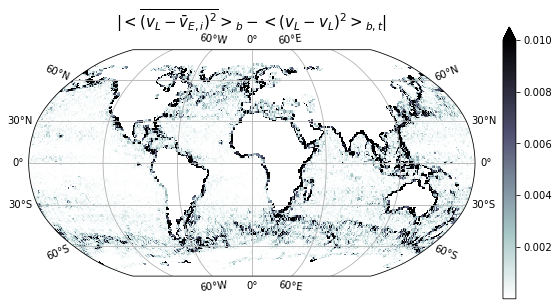

In [49]:
fig,ax = plot_maps(np.abs(ds_Estats['meridional_velocity_var']-ds_Lstats['meridional_velocity_iprime_square']),0.01,colmap='bone_r')
ax.set_title(r'$\vert <\overline{(v_E-\bar v_{E})^2}>_{b}- <(v_L-v_{E,i})^2>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['meridional_velocity_var']-ds_Lstats['meridional_velocity_bprime_square']),0.01,colmap='bone_r')
ax.set_title(r'$\vert <\overline{(v_E-\bar v_{E})^2}>_{b}- <(v_L-v_{L})^2>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Lstats['meridional_velocity_iprime_square']-ds_Lstats['meridional_velocity_bprime_square']),0.01,colmap='bone_r')
ax.set_title(r'$\vert <\overline{(v_L-\bar v_{E,i})^2}>_{b}- <(v_L-v_{L})^2>_{b,t}\vert$',fontsize=15)

In [51]:
ds_Estats['EKE'] = ds_Estats['zonal_velocity_var']+ds_Estats['meridional_velocity_var']
ds_Lstats['EKE_i'] = ds_Lstats['zonal_velocity_iprime_square']+ds_Lstats['meridional_velocity_iprime_square']
ds_Lstats['EKE_b'] = ds_Lstats['zonal_velocity_bprime_square']+ds_Lstats['meridional_velocity_bprime_square']

Text(0.5, 1.0, 'Lagrangian edd kinetic energy : $<(u_L-<u_L>_{b,t})^2}>_b+<(v_L-<v_L>_{b,t})^2}>_{b,t}$')

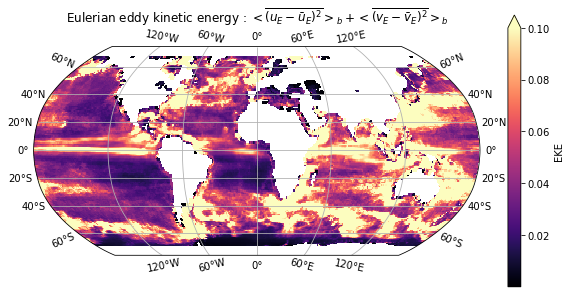

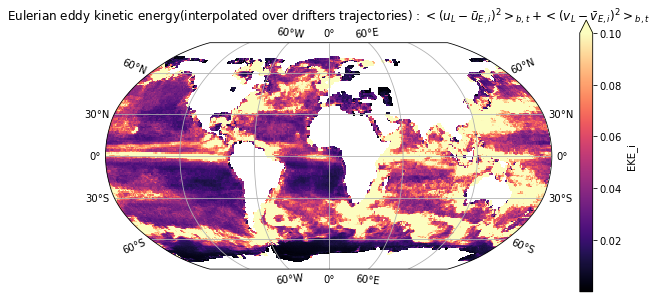

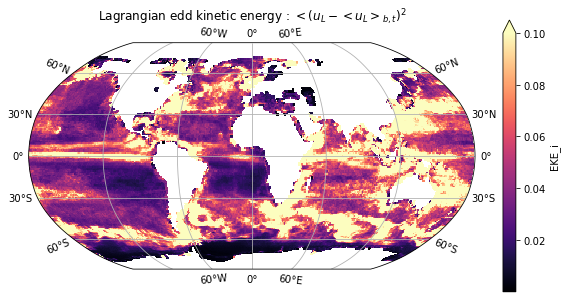

In [52]:
fig,ax = plot_maps(ds_Estats['EKE'],0.1,colmap='magma')
ax.set_title(r'Eulerian eddy kinetic energy : $<\overline{(u_E-\bar u_E)^2}>_b+<\overline{(v_E-\bar v_E)^2}>_b$')
fig,ax = plot_maps(ds_Lstats['EKE_i'],0.1,colmap='magma')
ax.set_title(r'Eulerian eddy kinetic energy(interpolated over drifters trajectories) : $<(u_L-\bar u_{E,i})^2>_{b,t}+<(v_L-\bar v_{E,i})^2>_{b,t}$')
fig,ax = plot_maps(ds_Lstats['EKE_i'],0.1,colmap='magma')
ax.set_title(r'Lagrangian edd kinetic energy : $<(u_L-<u_L>_{b,t})^2}>_b+<(v_L-<v_L>_{b,t})^2}>_{b,t}$')

Text(0.5, 1.0, '$EKE_{L,i}-EKE_{L,b}$')

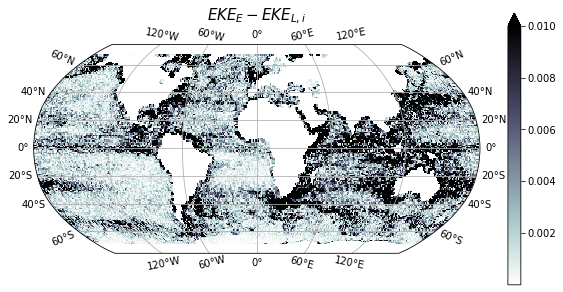

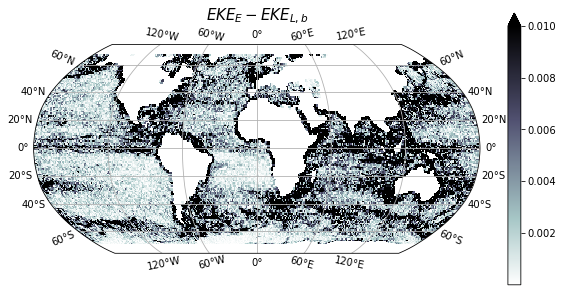

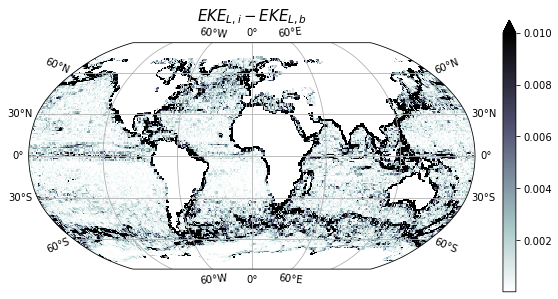

In [55]:
fig,ax = plot_maps(np.abs(ds_Estats['EKE']-ds_Lstats['EKE_i']),0.01,colmap='bone_r')
ax.set_title(r'$EKE_E-EKE_{L,i}$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['EKE']-ds_Lstats['EKE_b']),0.01,colmap='bone_r')
ax.set_title(r'$EKE_E-EKE_{L,b}$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Lstats['EKE_i']-ds_Lstats['EKE_b']),0.01,colmap='bone_r')
ax.set_title(r'$EKE_{L,i}-EKE_{L,b}$',fontsize=15)

### Mean square : 
1) $<\bar u_E^2>_b$
1) $<\bar u_{E,i}^2>_{b,t}$
3) $<u_L^2>_{b,t}$

In [21]:
ds_Lstats

<xarray.Dataset>
Dimensions:                            (lat: 179, lon: 359)
Coordinates:
  * lat                                (lat) float64 -89.5 -88.5 ... 87.5 88.5
  * lon                                (lon) float64 -179.5 -178.5 ... 178.5
Data variables: (12/30)
    EKE                                (lon, lat) float64 nan nan ... nan nan
    EKE_binned                         (lon, lat) float64 nan nan ... nan nan
    EKE_ibinned                        (lon, lat) float64 nan nan ... nan nan
    KE                                 (lon, lat) float64 nan nan ... nan nan
    mean_KE                            (lon, lat) float64 nan nan ... nan nan
    mean_KE_binned                     (lon, lat) float64 nan nan ... nan nan
    ...                                 ...
    zonal_velocity_binned_iprime       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_square              (lon, lat) float64 nan nan ... nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

### Eddy kinetic energy : $<\frac{1}{2}(u'^2+v'^2)>$
In Lagrangian perspective, $u'$ can be defined by two methods:

1) Binning, $\bar u_b$ : the velocity aloong drifters trajectory is binned and averaged over time and bins
2) Interpolation of Eulerian field, $\bar u_i$ : the Eulerian field is computed on the model grid and then interpolated over every drifters trajectory

The eddy kinetic energy can be computed in two differents ways:

1) $u-\bar u_b$
2) $u-\bar u_i$

Text(0.5, 1.0, '$(EKE_i-EKE_b)/EKE_i$')

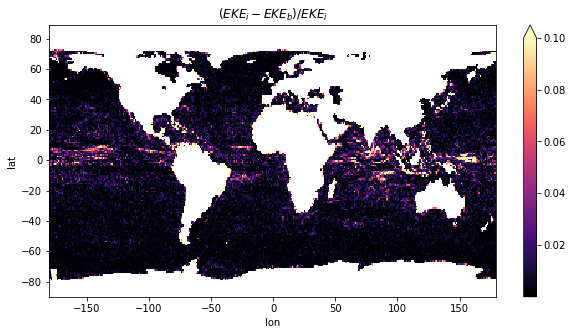

In [21]:
fig,ax = plt.subplots(figsize=(10,5))
((ds_Lstats.EKE_ibinned-ds_Lstats.EKE_binned)/ds_Lstats.EKE_ibinned).plot(y='lat',vmax=0.1,cmap=colmap,ax=ax)
ax.set_title(r'$(EKE_i-EKE_b)/EKE_i$')

In [113]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
